In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import inv_boxcox
from scipy.stats import anderson


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson


In [61]:
df1 = pd.read_csv("../ExploratoryDataAnalysis/cleaned_cardata.csv") 

##### **Step 1:**
**Get to know your data and `determine feature variables and the target variable`**.

In DataPreparation and ExploratoryDataAnalysis, there is a brief description of how to learn about your data. 

In [62]:
df1.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,6,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,7,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,3,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,9,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,6,4.60,6.87,42450,Diesel,Dealer,Manual,0


Before proceeding, we need to handle the categorical data by transforming them into nominal variables.

Here’s a line of code to do that using `pd.get_dummies`:

In [63]:

CatCols = df1.select_dtypes(include=['object', 'category']).columns.tolist()
df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head()


,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,6,3.35,5.59,27000,0,False,True,False,True
1,7,4.75,9.54,43000,0,True,False,False,True
2,3,7.25,9.85,6900,0,False,True,False,True
3,9,2.85,4.15,5200,0,False,True,False,True
4,6,4.60,6.87,42450,0,True,False,False,True


In [64]:
x = df1.drop("Selling_Price", axis=1)
y = df1["Selling_Price"]

##### **Step 2:**
**Split the data into feature variables and the target variable**.

In [65]:
X_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.25, random_state=0)

In [66]:
print (f"X_train shape: {X_train.shape} \n x_test shape: {x_test.shape} \n y_train shape: {y_train.shape} \n y_test shape: {y_test.shape}")

X_train shape: (224, 8) 
 x_test shape: (75, 8) 
 y_train shape: (224,) 
 y_test shape: (75,)


##### **Step 3:**
**Rescale the data**
We scale the data using `StandardScaler` to normalize features, ensuring they have a mean of 0 and a standard deviation of 1, which helps improve model performance and convergence. 

It's important to note: We apply `StandardScaler` to the training set only to avoid data leakage. This ensures that the scaling parameters (mean and standard deviation) are derived solely from the training data, and then these same parameters are used to scale the test set. This approach maintains the integrity of the model evaluation.

In [67]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Print parameters of a StandardScaler object: 

In [68]:
print(f"mean of features: {scaler.mean_} standard deviation of fearures: {scaler.scale_} \n Variance of features: {scaler.var_}")


mean of features: [6.44642857e+00 7.17341964e+00 3.66368705e+04 5.35714286e-02
 1.83035714e-01 8.08035714e-01 3.57142857e-01 9.06250000e-01] standard deviation of fearures: [2.99803294e+00 6.74785390e+00 3.04177123e+04 2.78365308e-01
 3.86695800e-01 3.93845146e-01 4.79157424e-01 2.91480595e-01] 
 Variance of features: [8.98820153e+00 4.55335323e+01 9.25237220e+08 7.74872449e-02
 1.49533642e-01 1.55113999e-01 2.29591837e-01 8.49609375e-02]


In [69]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(x_test)

##### **Step 4:** 

**Train the Model**

In [70]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [71]:
# an easy line of code: 
#pd.DataFrame(data = np.append(model.intercept_ , model.coef_), 
             #index = ['Intercept']+[col+" Coef." for col in x.columns], columns=['Value']).sort_values('Value', ascending=False)

coefficients = np.append(model.intercept_, model.coef_)
index_labels = ['Intercept'] + [f"{col} Coef." for col in x.columns]

for label, value in sorted(zip(index_labels, coefficients), key=lambda x: x[1], reverse=True):
    print(f"{label}: {value}")

Intercept: 4.307232142857143
Present_Price Coef.: 3.3919949896844828
Fuel_Type_Diesel Coef.: 0.8857088316129725
Fuel_Type_Petrol Coef.: 0.22293749378387578
Transmission_Manual Coef.: 0.02673230145067175
Owner Coef.: -0.2028061688207019
Seller_Type_Individual Coef.: -0.37390184163124474
Kms_Driven Coef.: -0.5539020244201995
Age Coef.: -0.8902615827192663


##### **Step 5:**

**Model Evaluation** 

The `evaluate_model` function calculates and returns key performance metrics for a given model. It computes the Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² Score based on predictions made on the test set. The results are returned in a DataFrame with the model name as the column label.

In [72]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_score = metrics.r2_score(y_test, y_pred)
    
    results = [mae, mse, rmse, r2_score]
    return pd.DataFrame(results, index=['MAE', 'MSE', 'RMSE', 'R2 Score'], columns=[model_name])


In [73]:
evaluate_model(model, X_test_scaled, y_test, 'Linear Regression.')

,Linear Regression.
MAE,1.185494
MSE,3.916044
RMSE,1.978900
R2 Score,0.893016


##### **Model Evaluation Using Cross-Validation**
Cross-validation provides a more reliable evaluation by splitting the data into multiple subsets, ensuring that the model's performance is assessed on different portions of the data, reducing the risk of overfitting and offering a better estimate of its generalization ability.

The following block of code performs cross-validation to evaluate a pipeline consisting of `StandardScaler` and `LinearRegression`. It uses K-Fold cross-validation with 5 splits and calculates various performance metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² Score. The results, including the mean and standard deviation of these metrics, are summarized and presented in a DataFrame.

Using a pipeline is an effective way to prevent data leakage, as it ensures that each processing step is applied only to the correct data subset. This is particularly useful in cross-validation, where it guarantees that fitting is done only on the training folds, while the test (validation) set is reserved solely for evaluating the model's accuracy in each iteration.

In [74]:
# Create a pipeline with StandardScaler and LinearRegression
pipeline = make_pipeline(scaler, model)

# Define the K-Fold cross-validation parameters
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define the metrics for cross-validation
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']

# Perform cross-validation
results = cross_validate(pipeline, x, y, cv=kf, return_train_score=True, scoring=scoring)

# Calculate mean and standard deviation for each metric
metrics_summary = {
    'Mean': [
        -results['test_neg_mean_absolute_error'].mean(),
        -results['test_neg_mean_squared_error'].mean(),
        -results['test_neg_root_mean_squared_error'].mean(),
        results['test_r2'].mean()
    ],
    'Std': [
        -results['test_neg_mean_absolute_error'].std(),
        -results['test_neg_mean_squared_error'].std(),
        -results['test_neg_root_mean_squared_error'].std(),
        results['test_r2'].std()
    ]
}

# Create a DataFrame to display the results
metrics_df = pd.DataFrame(metrics_summary, index=['MAE', 'MSE', 'RMSE', 'R2 Score'])
metrics_df


,Mean,Std
MAE,1.166440,-0.138536
MSE,3.127017,-1.393687
RMSE,1.725377,-0.387417
R2 Score,0.854317,0.054281



We check model assumptions to ensure the validity and accuracy of the linear regression results. Violating these assumptions can lead to biased estimates, incorrect conclusions, and poor model performance.


##### **Step 6:**

**Checking Model Assumptions in Linear Regression:** 

6.1. **Linearity:** Ensure a linear relationship exists between the independent variables and the dependent variable.
   - **How:** Plot the predicted values against the actual values.

6.2. **Independence:** Check that the residuals (errors) are independent of each other.
   - **How:** Use the Durbin-Watson test.

6.3. **Homoscedasticity:** Verify that the residuals have constant variance.
   - **How:** Plot the residuals against the predicted values.

6.4. **Normality:** Confirm that the residuals are normally distributed.
   - **How:** Use a Q-Q plot or a histogram of residuals.

6.5. **No Multicollinearity:** Check that the independent variables are not highly correlated with each other.
   - **How:** Calculate the Variance Inflation Factor (VIF) for each predictor.

These checks help validate that the assumptions of linear regression are met, ensuring the model's reliability.

6.1. **Linearity:**

In [75]:
def calculate_residuals(model, X_test, y_test):
    """
    Generates predictions using the model and calculates residuals.
    """
    y_pred = model.predict(X_test)
    df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def check_linearity_assumption(model, X_test, y_test):
    """
    Visually inspects the linearity assumption in a linear regression model.
    """
    df_results = calculate_residuals(model, X_test, y_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
    
    # Plotting Actual vs. Predicted Values
    sns.regplot(x='Predicted', y='Actual', data=df_results,  ax=ax[0],
                color='#0055ff', line_kws={'color':'#ff7000', 'ls':'--', 'lw':2.5})
    ax[0].set_title('Actual vs. Predicted Values', fontsize=15)
    ax[0].set_xlabel('Predicted', fontsize=12)
    ax[0].set_ylabel('Actual', fontsize=12)
    
    # Plotting Residuals vs. Predicted Values
    sns.regplot(x='Predicted', y='Residuals', data=df_results,  ax=ax[1],
                color='#0055ff', line_kws={'color':'#ff7000', 'ls':'--', 'lw':2.5})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=15)
    ax[1].set_xlabel('Predicted', fontsize=12)
    ax[1].set_ylabel('Residuals', fontsize=12)


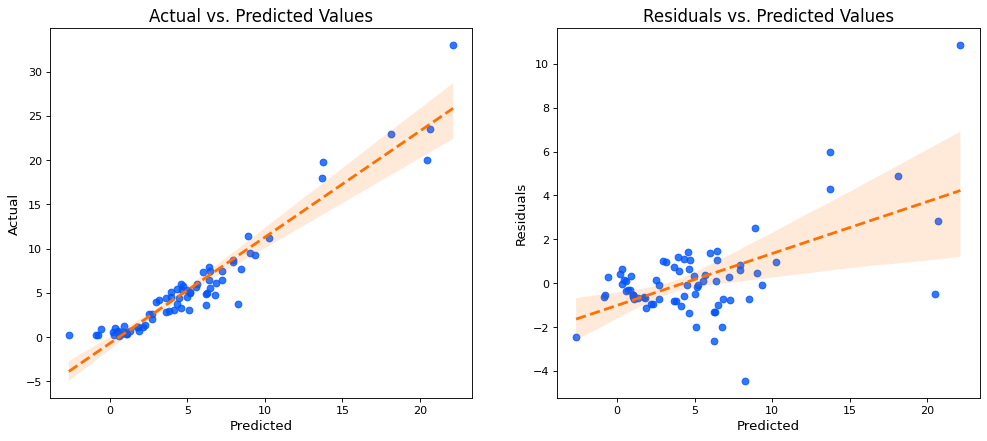

In [76]:
check_linearity_assumption(model, X_test_scaled, y_test)

6.2. **Independence:**

The `autocorrelation_assumption` function assesses whether the residuals from a regression model exhibit autocorrelation. It calculates the Durbin-Watson statistic to test for serial correlation in the residuals. The function prints whether the residuals show signs of positive or negative autocorrelation or if the assumption of no autocorrelation is satisfied.

In [95]:
def residuals(model, X_test, y_test):
    """
    Computes the residuals for a given model using test data.
    
    Parameters:
    - model: The trained model to make predictions.
    - X_test: The feature matrix for the test set.
    - y_test: The actual target values for the test set.
    
    Returns:
    - A DataFrame containing the actual values, predicted values, and residuals.
    """
    # Make predictions using the model
    y_pred = model.predict(X_test)
    
    # Create a DataFrame to store the actual, predicted, and residual values
    df_results = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    
    # Calculate residuals
    df_results['Residuals'] = df_results['Actual'] - df_results['Predicted']
    
    return df_results



def autocorrelation_assumption(model, X_test, y_test):
    '''
    Checks the assumption of no autocorrelation in the residuals.
    Autocorrelation indicates that residuals are not independent, which suggests that the model
    may be missing important information.
    '''
    df_results = residuals(model, X_test, y_test)

    # Calculate Durbin-Watson statistic
    durbin_watson_stat = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson Statistic:', round(durbin_watson_stat, 3))
    
    # Interpret Durbin-Watson statistic
    if durbin_watson_stat < 1.5:
        print('Possible positive autocorrelation detected. Assumption not satisfied.')
    elif durbin_watson_stat > 2.5:
        print('Possible negative autocorrelation detected. Assumption not satisfied.')
    else:
        print('No significant autocorrelation detected. Assumption satisfied.')



In [96]:
autocorrelation_assumption(model, X_test_scaled, y_test)

Durbin-Watson Statistic: 1.826
No significant autocorrelation detected. Assumption satisfied.


6.3. **Homoscedasticity:**

In [106]:
def homoscedasticity_assumption(model, X_test, y_test):
    """
    Checks the assumption of homoscedasticity, which states that residuals should have constant variance.
    This function plots residuals versus predicted values to visually inspect for constant variance.
    """
    print('The horizontal line should be flat if homoscedasticity assumption is met.')
    
    # Calculate residuals
    df_results = residuals(model, X_test, y_test)
    
    # Create the plot
    plt.figure(figsize=(6, 6), dpi=80)
    sns.regplot(x='Predicted', y='Residuals', data=df_results, 
                color='b', line_kws={'color':'r', 'ls':'--', 'lw':2.5})
    plt.axhline(y=0, color='k', lw=1)
    plt.title('Residuals vs. Predicted Values', fontsize=15)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.show()


The horizontal line should be flat if homoscedasticity assumption is met.


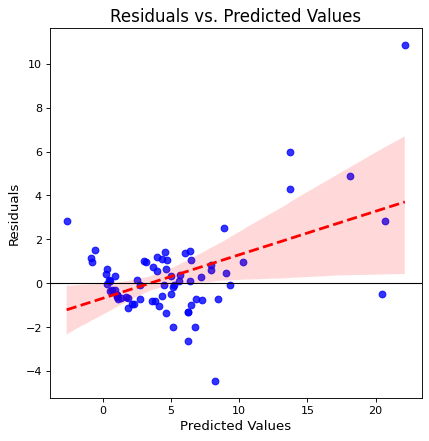

In [107]:
homoscedasticity_assumption(model, X_test_scaled, y_test)

6.4. **Normality:**

This function checks the normality assumption of residuals in a linear regression model. It uses the Anderson-Darling test to assess normality and provides visualizations, including a histogram and Q-Q plot of the residuals, to help determine if they are normally distributed. If the residuals are not normally distributed, it suggests that the linear regression model's assumptions may not be fully met.

In [77]:
def normal_anderson(residuals):
    """
    Perform the Anderson-Darling test for normality on the residuals.
    Returns the test statistic and p-value.
    """
    result = anderson(residuals, dist='norm')
    
    # Convert the significance level into a p-value-like format
    p_value = np.interp(result.statistic, result.critical_values, [0.15, 0.10, 0.05, 0.025, 0.01])
    
    # Return the test statistic and the p-value
    return result.statistic, p_value




def check_normality_of_residuals(model, X_test, y_test, p_value_threshold=0.05):
    """
    Inspects the normality assumption of residuals using the Anderson-Darling test and visualizations.
    """
    df_results = calculate_residuals(model, X_test, y_test)
    
    # Anderson-Darling Test for Normality
    p_value = normal_anderson(df_results['Residuals'])[1]
    
    print(f'\nP-value from the test (below {p_value_threshold} generally indicates non-normality): {np.round(p_value, 6)}')
    if p_value < p_value_threshold:
        print('Residuals are not normally distributed. Assumption not satisfied.') 
    else:
        print('Residuals are normally distributed. Assumption satisfied.')
      
    # Visualizations: Residuals Histogram and Q-Q Plot
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
    
    # Plotting the distribution of residuals
    sns.histplot(data=df_results, x='Residuals', kde=True, ax=ax[0], bins=15, 
                 color='#0055ff', edgecolor='none', alpha=0.4, line_kws={'lw': 2.5})
    ax[0].set_xlabel('Residuals', fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_title('Distribution of Residuals', fontsize=15)
    
    # Displaying mean and standard deviation of residuals
    textstr = f'$\mu={np.mean(df_results["Residuals"]):.2f}$\n$\sigma={np.std(df_results["Residuals"]):.2f}$'
    ax[0].text(0.7, 0.9, textstr, transform=ax[0].transAxes, fontsize=15, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='#509aff', edgecolor='black', pad=0.5))
    
    # Q-Q Probability Plot
    stats.probplot(df_results['Residuals'], dist="norm", plot=ax[1])
    ax[1].set_title("Residuals Q-Q Plot", fontsize=15)
    ax[1].set_xlabel('Theoretical Quantiles', fontsize=12)
    ax[1].set_ylabel('Ordered Values', fontsize=12)
    ax[1].get_lines()[0].set_markerfacecolor('#509aff')
    ax[1].get_lines()[1].set_color('#ff7000')
    ax[1].get_lines()[1].set_linewidth(2.5)
    ax[1].get_lines()[1].set_linestyle('--')
    ax[1].legend(['Actual', 'Theoretical'])
    
    plt.show()



P-value from the test (below 0.05 generally indicates non-normality): 0.01
Residuals are not normally distributed. Assumption not satisfied.


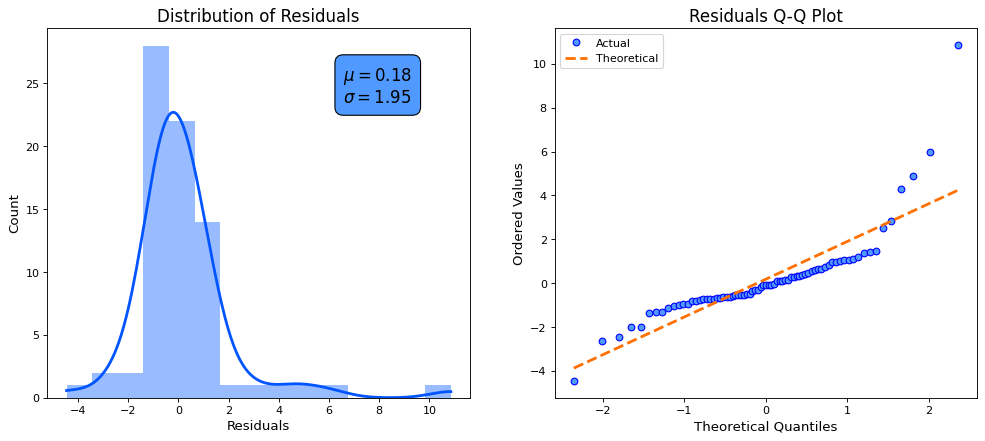

In [78]:
check_normality_of_residuals(model, X_test_scaled, y_test)

6.5. **No Multicollinearity:**

The following function checks for multicollinearity among predictors in a dataset by calculating Variance Inflation Factor (VIF) values. It identifies potential issues where VIF exceeds thresholds of 10 and 100, indicating possible or definite multicollinearity. The results help determine if the multicollinearity assumption is satisfied, potentially satisfied, or not satisfied.

In [86]:
def check_multicollinearity(X):
    """
    Evaluates multicollinearity among predictors by calculating Variance Inflation Factor (VIF) values.
    """
    # Calculate VIF for each predictor
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Identify possible and definite multicollinearity cases
    possible_multicollinearity = sum(v > 10 for v in vif)
    definite_multicollinearity = sum(v > 100 for v in vif)
    
    # Output results
    print(f'{possible_multicollinearity} cases of possible multicollinearity.')
    print(f'{definite_multicollinearity} cases of definite multicollinearity.')
    
    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied.')
        else:
            print('Assumption possibly satisfied.')
    else:
        print('Assumption not satisfied.')
    
    # Return VIF values in a DataFrame
    return pd.DataFrame({'VIF': vif}, index=X.columns).round(2)


In [93]:
# Convert boolean columns to integers (False -> 0, True -> 1)
boolean_columns = ['Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Seller_Type_Individual', 'Transmission_Manual']
x_[boolean_columns] = x[boolean_columns].astype(int)

check_multicollinearity(x_)

2 cases of possible multicollinearity.
0 cases of definite multicollinearity.
Assumption possibly satisfied.


,VIF
Age,10.64
Present_Price,5.14
Kms_Driven,5.33
Owner,1.10
Fuel_Type_Diesel,6.25
Fuel_Type_Petrol,17.84
Seller_Type_Individual,2.61
Transmission_Manual,9.60
